## Introducción
Las **Redes Neuronales Convolucionales (CNNs)** son un tipo de red neuronal especialmente eficaz para el procesamiento de imágenes. Son ampliamente utilizadas en tareas como reconocimiento facial, clasificación de imágenes, detección de objetos y más.

En este cuaderno exploraremos cómo se construye, entrena y evalúa una CNN utilizando un dataset estándar. Este material está pensado con fines pedagógicos para estudiantes de la materia *Procesamiento Digital de Imágenes*.

In [1]:
# Importamos las bibliotecas necesarias.
# TensorFlow es la librería principal para construir y entrenar redes neuronales.
# TensorFlow Datasets (tfds) nos permite acceder fácilmente a conjuntos de datos predefinidos.
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
# Cargamos el dataset MNIST desde TensorFlow Datasets.
# MNIST contiene imágenes de dígitos escritos a mano (0 al 9).
# 'as_supervised=True' indica que queremos los datos en pares (imagen, etiqueta).
# 'with_info=True' incluye información adicional sobre el dataset (metadatos).
datos, metadatos = tfds.load("mnist", as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.FFL3N3_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.FFL3N3_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
# Imprimimos los metadatos para conocer detalles del dataset (tamaño, clases, etc.).
metadatos

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year

## Carga y Preparación de Datos

En esta sección, vamos a cargar el dataset MNIST y realizar algunas preparaciones importantes para que los datos sean adecuados para el entrenamiento de nuestra red neuronal. Esto incluye la normalización de los valores de píxeles y la división en conjuntos de entrenamiento y prueba.

In [4]:
# Separamos los datos en conjuntos de entrenamiento y prueba.
datos_entrenamiento = datos["train"]
datos_pruebas = datos["test"]

In [5]:
# Accedemos a los nombres de las clases (0 a 9) desde los metadatos.
nombres_clases = metadatos.features["label"].names

In [6]:
# Definimos una función para normalizar las imágenes.
# La normalización lleva los valores de los píxeles al rango [0, 1], lo cual ayuda al entrenamiento.
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)  # Convertimos a tipo float32 para la división.
  imagenes /= 255  # Dividimos por 255 para normalizar los valores.
  return imagenes, etiquetas

# Aplicamos la función de normalización a los conjuntos de entrenamiento y prueba.
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

# Almacenamos en caché los datos transformados para mejorar el rendimiento.
# La caché evita tener que recalcular las transformaciones en cada época.
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

## Visualización de los datos

Antes de entrenar cualquier modelo, es importante **visualizar** ejemplos del dataset para tener una idea de qué tipo de datos estamos procesando. Esto nos ayuda a comprender la tarea que la red neuronal debe aprender.

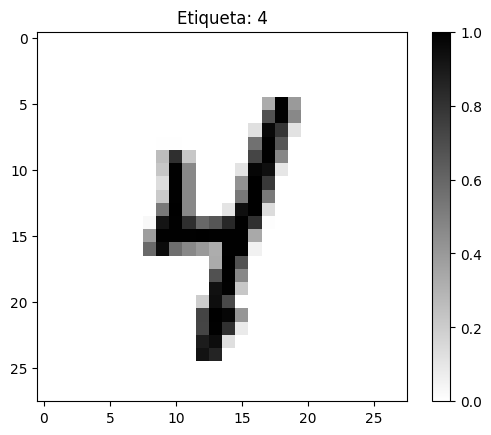

In [7]:
# Visualizamos una imagen del dataset.
for imagen, etiqueta in datos_entrenamiento.take(1):
  break  # Tomamos solo el primer ejemplo.

import matplotlib.pyplot as plt

# Mostramos la imagen en escala de grises.
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)  # 'binary' es para escala de grises.
plt.colorbar()  # Muestra la barra de color.
plt.title(f"Etiqueta: {etiqueta.numpy()}")
plt.show()

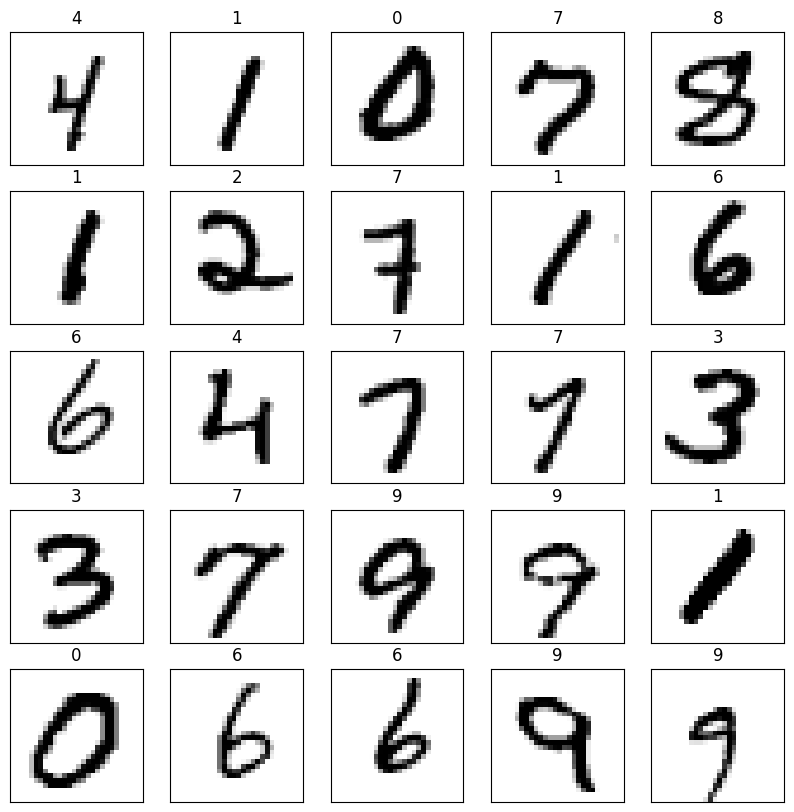

In [8]:
# Visualizamos múltiples imágenes del conjunto de entrenamiento.
plt.figure(figsize=(10, 10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  plt.subplot(5, 5, i + 1)  # Creamos una grilla de 5x5.
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xticks([])  # Ocultamos los ticks del eje x.
  plt.yticks([])  # Ocultamos los ticks del eje y.
  plt.title(nombres_clases[etiqueta.numpy()])  # Mostramos la etiqueta como título.

plt.show()

In [9]:
# Definimos la arquitectura de la Red Neuronal Convolucional (CNN).
# Utilizamos la API secuencial de Keras para construir el modelo capa por capa.
modelo = tf.keras.Sequential([
    # Primera capa convolucional: 32 filtros de tamaño 3x3.
    # 'input_shape' especifica la forma de las imágenes de entrada (28x28 píxeles, 1 canal: escala de grises).
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    # Max pooling: reduce la dimensionalidad espacial.
    tf.keras.layers.MaxPooling2D(2, 2),

    # Segunda capa convolucional: 64 filtros de tamaño 3x3.
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Aplanamos la salida de las capas convolucionales para conectarla con las capas densas.
    tf.keras.layers.Flatten(),
    # Capa densa (totalmente conectada) con 100 neuronas y activación ReLU.
    tf.keras.layers.Dense(units=100, activation='relu'),
    # Capa de salida con 10 neuronas (una por cada clase) y activación softmax.
    # Softmax produce una distribución de probabilidad sobre las clases.
    tf.keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Compilamos el modelo.
# 'adam' es un optimizador popular.
# 'sparse_categorical_crossentropy' es la función de pérdida adecuada para clasificación multiclase con etiquetas enteras.
# 'accuracy' es la métrica que usaremos para evaluar el rendimiento.
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

## Construcción del modelo

Aquí definimos la arquitectura de la red neuronal convolucional. Incluiremos capas convolucionales, funciones de activación ReLU, capas de pooling, y finalmente capas densas. La estructura de la red está diseñada para extraer características relevantes de las imágenes y clasificarlas en una de las 10 clases posibles (dígitos del 0 al 9).

In [11]:
# Definimos el tamaño del lote (batch size).
# El tamaño del lote determina cuántas imágenes se procesan a la vez durante el entrenamiento.
TAMANO_LOTE = 32

# Preparamos los datos de entrenamiento.
# 'repeat()' hace que el dataset se repita indefinidamente (útil para el entrenamiento por épocas).
# 'shuffle(60000)' mezcla aleatoriamente los datos (importante para evitar sesgos).
# 'batch(TAMANO_LOTE)' agrupa las imágenes en lotes.
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(60000).batch(TAMANO_LOTE)
# Preparamos los datos de prueba.
# No necesitamos mezclar los datos de prueba, solo agruparlos en lotes.
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [12]:
# Importamos la biblioteca math para calcular el número de pasos por época.
import math

# Entrenamos el modelo.
# 'epochs' especifica cuántas veces se iterará sobre todo el dataset de entrenamiento.
# 'steps_per_epoch' define cuántos lotes se procesarán en cada época.
# Calculamos el número de pasos dividiendo el tamaño del dataset entre el tamaño del lote.
ENTRENAMIENTO = modelo.fit(
    datos_entrenamiento, epochs=10,
    steps_per_epoch=math.ceil(60000/TAMANO_LOTE)  # 60000 es el tamaño del dataset de entrenamiento.
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9101 - loss: 0.2986
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9840 - loss: 0.0514
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9897 - loss: 0.0325
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9926 - loss: 0.0218
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9946 - loss: 0.0172
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9952 - loss: 0.0157
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9967 - loss: 0.0097
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9967 - loss: 0.0097
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9975 - loss: 0.0080
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9974 - loss: 0.0080


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


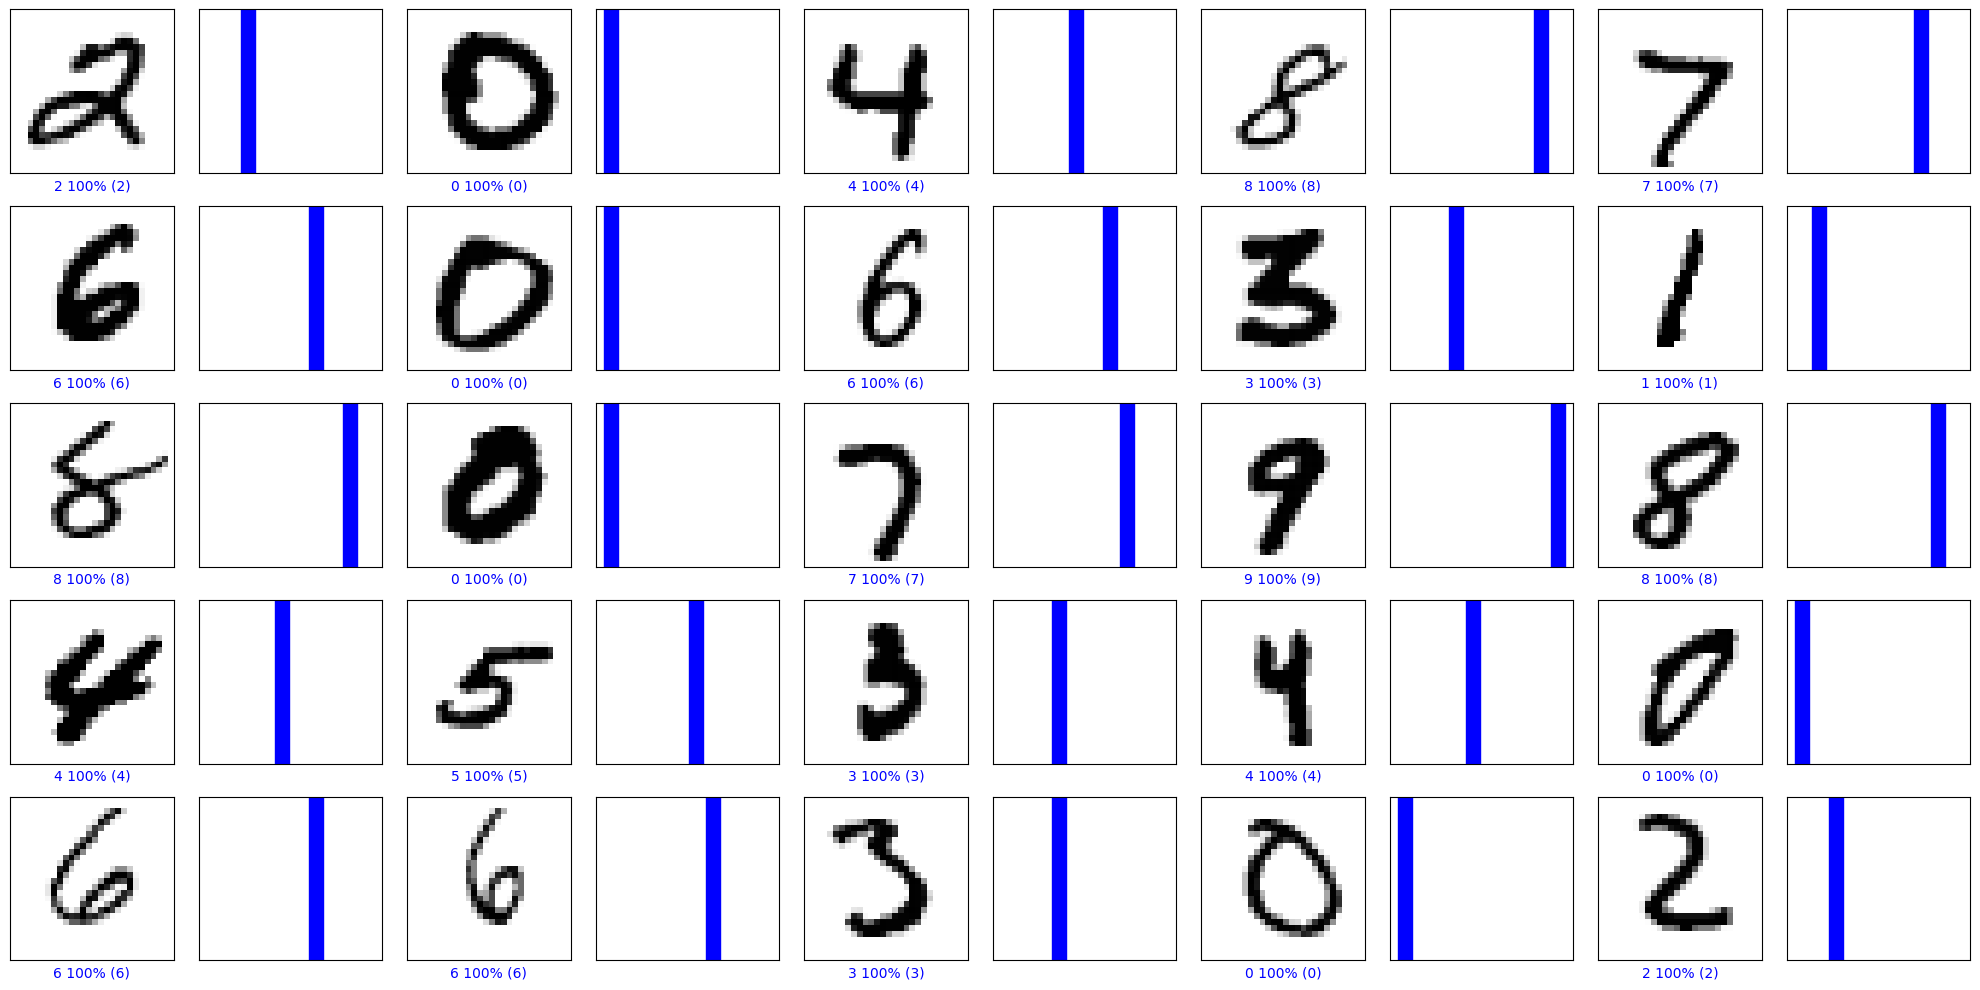

In [13]:
# Visualización de predicciones.
# Tomamos un lote de imágenes de prueba y las usamos para hacer predicciones.
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)

# Función para graficar una imagen con su predicción y etiqueta real.
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[..., 0], cmap=plt.cm.binary)  # Mostramos la imagen en escala de grises.

  etiqueta_prediccion = np.argmax(arr_predicciones)  # Obtenemos la clase predicha.
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'  # Color azul si la predicción es correcta.
  else:
    color = 'red'  # Color rojo si la predicción es incorrecta.

  plt.xlabel("{} {:2.0f}% ({})".format(
      nombres_clases[etiqueta_prediccion],
      100*np.max(arr_predicciones),  # Porcentaje de confianza en la predicción.
      nombres_clases[etiqueta_real]),  # Etiqueta real.
      color=color
  )

# Función para graficar los valores de predicción (probabilidades).
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")  # Barras grises.
  plt.ylim([0, 1])  # Limitamos el eje y al rango [0, 1].
  etiqueta_prediccion = np.argmax(arr_predicciones)

  grafica[etiqueta_prediccion].set_color('red')  # Resaltamos la predicción con rojo.
  grafica[etiqueta_real].set_color('blue')  # Resaltamos la etiqueta real con azul.

# Visualizamos las predicciones en una cuadrícula.
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)
plt.tight_layout()
plt.show()

In [14]:
#Cargar Otro dataset
# Cargamos el dataset "cats_vs_dogs" desde TensorFlow Datasets.
# Este conjunto de datos contiene imágenes de gatos y perros.
datos, metadatos = tfds.load("cats_vs_dogs", as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.SNIAXZ_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [15]:
# Imprimimos los metadatos para conocer detalles del dataset (tamaño, clases, etc.).
metadatos

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, Jo

## Compilación y entrenamiento del modelo
Compilamos el modelo con una función de pérdida y un optimizador, y luego lo entrenamos usando los datos cargados.

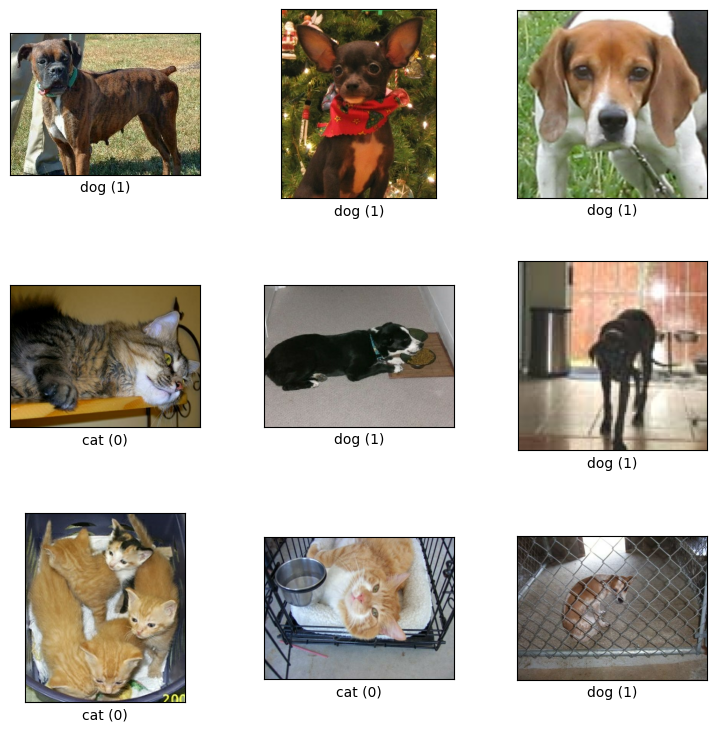

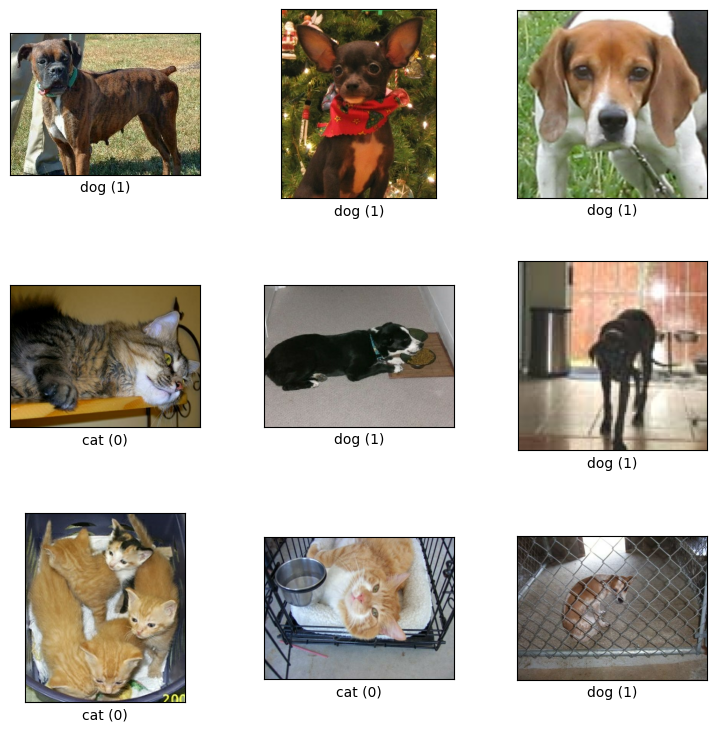

In [16]:
# Mostramos ejemplos del dataset "cats_vs_dogs".
# Esto nos da una idea de la variedad de imágenes que contiene el dataset.
tfds.show_examples(datos["train"], metadatos)

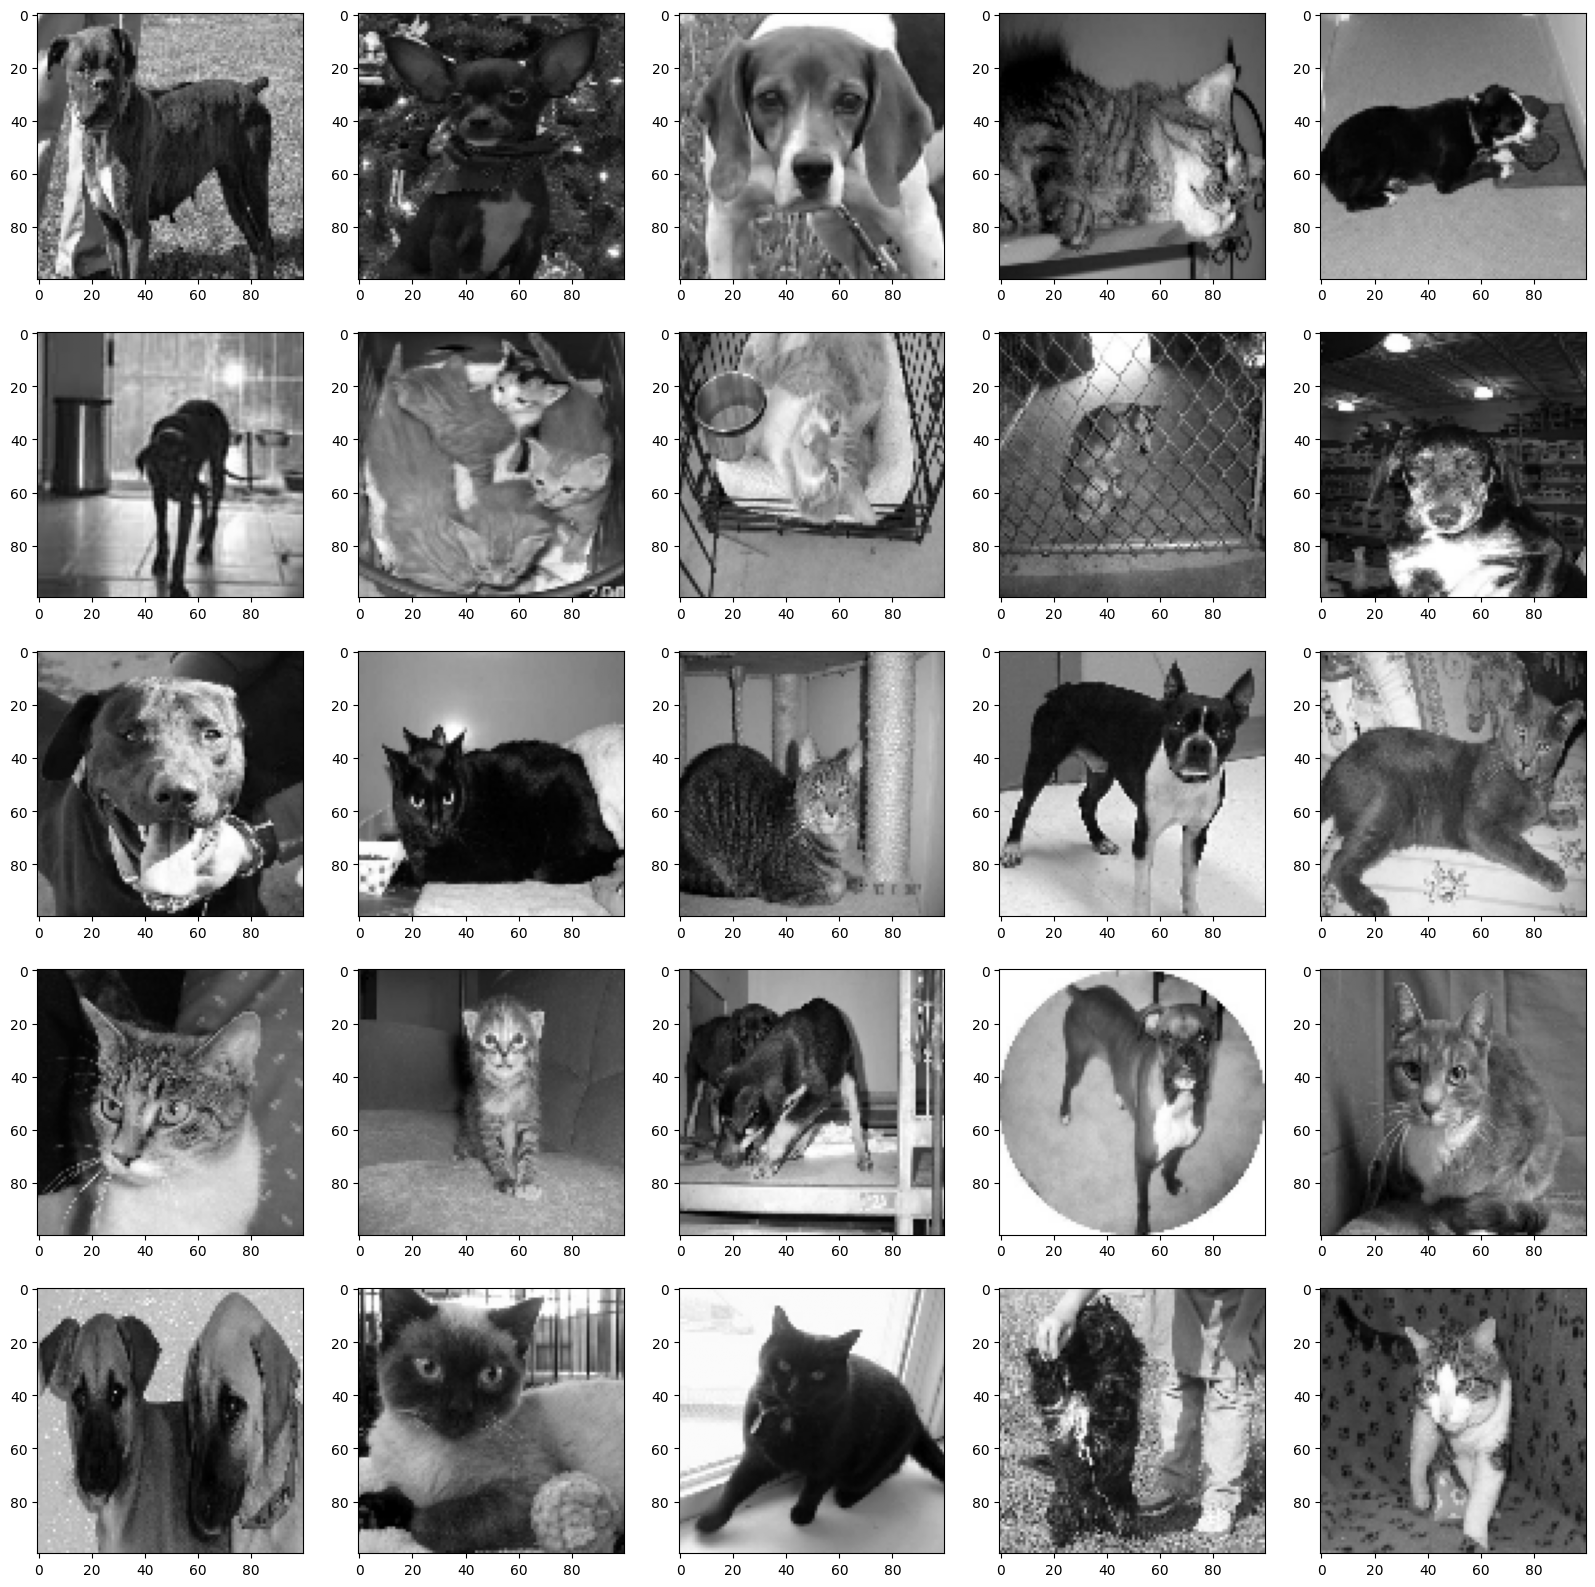

In [17]:
# Visualización de imágenes del dataset "cats_vs_dogs".
# Adaptamos el tamaño y la conversión de color de las imágenes.
import matplotlib.pyplot as plt
import cv2  # OpenCV para transformaciones de imágenes.

plt.figure(figsize=(20, 20))

TAMANO_IMG = 100  # Tamaño deseado para las imágenes.

for i, (imagen, etiqueta) in enumerate(datos["train"].take(25)):
  imagen = cv2.resize(imagen.numpy(), (TAMANO_IMG, TAMANO_IMG))  # Redimensionamos la imagen.
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)  # Convertimos a escala de grises.
  plt.subplot(5, 5, i+1)
  plt.imshow(imagen, cmap="gray")

In [18]:
# Preparamos los datos para el entrenamiento.
# Almacenaremos las imágenes y etiquetas en listas separadas.
datos_entrenamiento = []

In [19]:
# Procesamos las imágenes y las agregamos a la lista 'datos_entrenamiento'.
for i, (imagen, etiqueta) in enumerate(datos["train"]):
  imagen = cv2.resize(imagen.numpy(), (TAMANO_IMG, TAMANO_IMG))
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  imagen = imagen.reshape(TAMANO_IMG, TAMANO_IMG, 1)  # Agregamos una dimensión para el canal (escala de grises).
  datos_entrenamiento.append([imagen, etiqueta])

In [20]:
# Mostramos un ejemplo de los datos procesados.
# Esto nos permite verificar que las imágenes se han redimensionado y convertido correctamente.
datos_entrenamiento[0]

[array([[[249],
         [190],
         [105],
         ...,
         [189],
         [196],
         [143]],
 
        [[232],
         [127],
         [ 88],
         ...,
         [187],
         [180],
         [186]],
 
        [[171],
         [ 87],
         [ 83],
         ...,
         [129],
         [158],
         [166]],
 
        ...,
 
        [[113],
         [173],
         [162],
         ...,
         [143],
         [156],
         [119]],
 
        [[140],
         [152],
         [171],
         ...,
         [ 98],
         [155],
         [154]],
 
        [[ 91],
         [109],
         [167],
         ...,
         [ 46],
         [ 51],
         [ 47]]], dtype=uint8),
 <tf.Tensor: shape=(), dtype=int64, numpy=1>]

## Evaluación del modelo
Evaluamos el rendimiento del modelo sobre datos que no ha visto antes. Esto nos permite ver qué tan bien generaliza.

In [21]:
# Preparamos los datos en formato de arrays NumPy.
# Esto facilita el entrenamiento con Keras.

# Separamos las imágenes (X) y las etiquetas (y).
X = []
y = []

for imagen, etiqueta in datos_entrenamiento:
  X.append(imagen)
  y.append(etiqueta)

In [22]:
# Convertimos las listas a arrays NumPy.
# Normalizamos las imágenes dividiendo por 255.
import numpy as np

X = np.array(X).astype(float) / 255  # Normalizamos los valores de píxeles.


In [23]:
# Mostramos un ejemplo de las imágenes normalizadas.
# Esto nos permite verificar que la normalización se ha realizado correctamente.
X[0]

array([[[0.97647059],
        [0.74509804],
        [0.41176471],
        ...,
        [0.74117647],
        [0.76862745],
        [0.56078431]],

       [[0.90980392],
        [0.49803922],
        [0.34509804],
        ...,
        [0.73333333],
        [0.70588235],
        [0.72941176]],

       [[0.67058824],
        [0.34117647],
        [0.3254902 ],
        ...,
        [0.50588235],
        [0.61960784],
        [0.65098039]],

       ...,

       [[0.44313725],
        [0.67843137],
        [0.63529412],
        ...,
        [0.56078431],
        [0.61176471],
        [0.46666667]],

       [[0.54901961],
        [0.59607843],
        [0.67058824],
        ...,
        [0.38431373],
        [0.60784314],
        [0.60392157]],

       [[0.35686275],
        [0.42745098],
        [0.65490196],
        ...,
        [0.18039216],
        [0.2       ],
        [0.18431373]]])

In [24]:
# Mostramos las etiquetas.
# Estas son las etiquetas que usaremos para entrenar el modelo.
y

[<tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64

In [25]:
# Convertimos las etiquetas a un array NumPy.
y = np.array(y)

## Predicción y visualización
Finalmente, realizamos predicciones con el modelo entrenado y mostramos visualmente los resultados.

In [26]:
# Definimos la arquitectura de la CNN para "cats_vs_dogs".
# Usamos una arquitectura similar a la anterior, pero adaptada a este dataset.
modelo = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Capa de salida con activación sigmoid (clasificación binaria).
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
# Compilamos el modelo para "cats_vs_dogs".
# 'binary_crossentropy' es la función de pérdida adecuada para clasificación binaria.
modelo.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']
)

In [28]:
# Entrenamos el modelo para "cats_vs_dogs".
# 'validation_split' divide los datos en entrenamiento y validación.
modelo.fit(
    X, y, batch_size=32, validation_split=0.15, epochs=50
)

Epoch 1/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.5783 - loss: 0.6714 - val_accuracy: 0.6811 - val_loss: 0.5961
Epoch 2/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7316 - loss: 0.5356 - val_accuracy: 0.7232 - val_loss: 0.5429
Epoch 3/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7897 - loss: 0.4410 - val_accuracy: 0.8140 - val_loss: 0.4143
Epoch 4/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8302 - loss: 0.3761 - val_accuracy: 0.8195 - val_loss: 0.4003
Epoch 5/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8634 - loss: 0.3132 - val_accuracy: 0.8355 - val_loss: 0.3799
Epoch 6/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8889 - loss: 0.2572 - val_accuracy: 0.8284 - val_loss: 0.4273
Epoch 7/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9136 - loss: 0.2118 - val_accuracy: 0.8401 - val_loss: 0.4015
Epoch 8/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9365 - loss: 0.1543 - va

#Visualización de Predicciones para Gatos y Perros

Para verificar el rendimiento de nuestro modelo en el dataset "cats_vs_dogs", visualizaremos algunas imágenes de muestra junto con sus predicciones y la probabilidad asociada. Esto nos permitirá entender de manera intuitiva si el modelo está clasificando correctamente.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step


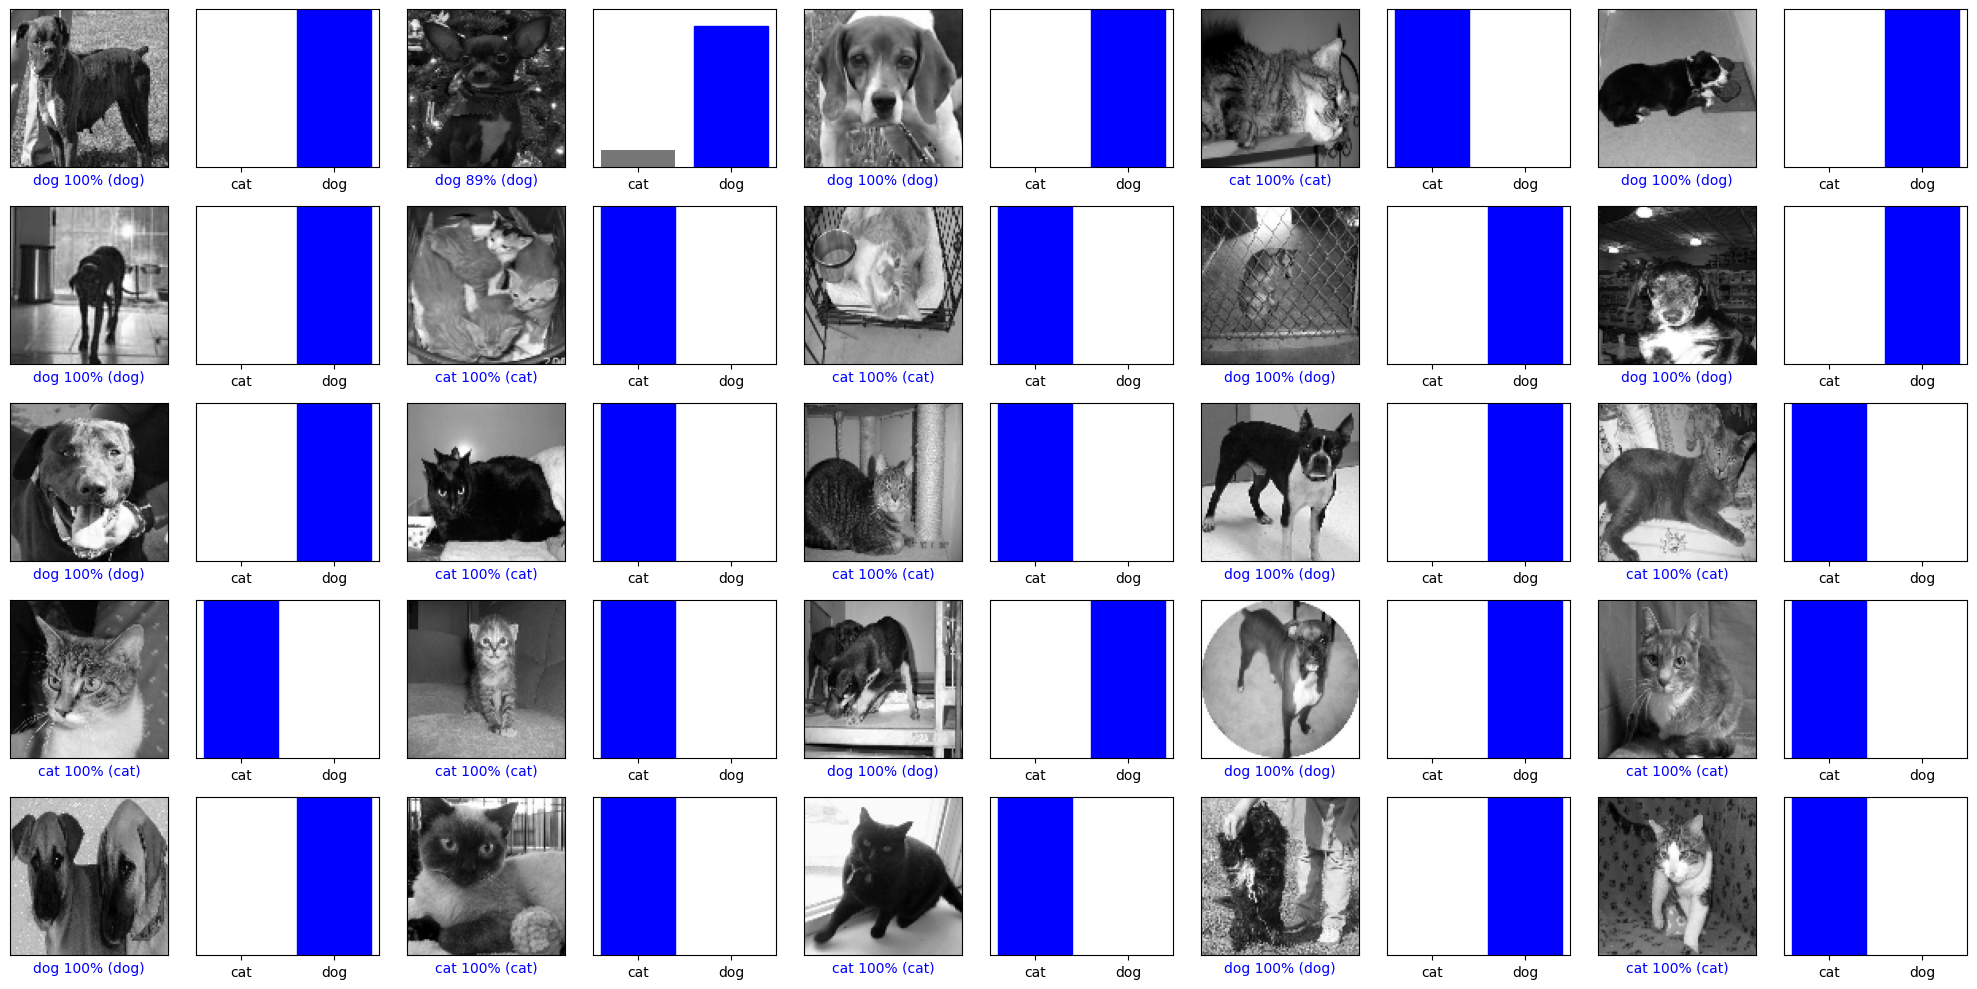

In [29]:
# Importamos las librerías necesarias. Ya deberían estar importadas en celdas anteriores.
# import matplotlib.pyplot as plt
# import numpy as np

# Definimos las dimensiones de la cuadrícula para la visualización.
filas = 5
columnas = 5
num_imagenes = filas * columnas
plt.figure(figsize=(2 * 2 * columnas, 2 * filas)) # Ajuste el tamaño de la figura para dos gráficos por imagen

# --- Preparación de datos de muestra para la visualización ---
# Asumimos que 'X' (imágenes preprocesadas) y 'y' (etiquetas)
# del dataset cats_vs_dogs ya están cargados y listos de celdas anteriores.
imagenes_cvd_sample = []
etiquetas_cvd_sample = []

# Tomamos las primeras 'num_imagenes' del conjunto de datos procesado (X y y).
for i in range(num_imagenes):
    if i < len(X): # Aseguramos no exceder el tamaño de los datos disponibles
        imagenes_cvd_sample.append(X[i])
        etiquetas_cvd_sample.append(y[i])
    else:
        break

imagenes_cvd_sample = np.array(imagenes_cvd_sample)
etiquetas_cvd_sample = np.array(etiquetas_cvd_sample)

# Realizamos las predicciones utilizando el modelo entrenado ('modelo').
predicciones_cvd = modelo.predict(imagenes_cvd_sample)
# --- Fin de la preparación de datos y predicciones ---

# Definimos los nombres de las clases para el dataset de gatos y perros.
# Obtenemos los nombres de las clases directamente de los metadatos del dataset.
clases_cvd = metadatos.features["label"].names

# --- Funciones de graficación adaptadas para clasificación binaria ---

def graficar_imagen_cvd(i, arr_predicciones, etiquetas_reales, imagenes):
  # La salida del modelo es una probabilidad de la clase 1 (jirafa/dog).
  # arr_predicciones[i] es un array con un solo valor de probabilidad (ej. [0.98]).
  prediccion_probabilidad_clase_1 = arr_predicciones[i][0]
  etiqueta_real = etiquetas_reales[i]
  img = imagenes[i]

  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  # Mostramos la imagen en escala de grises. (Asumimos que las imágenes son monocromáticas).
  # Aseguramos que la imagen tenga la forma correcta (alto, ancho) para mostrarla.
  plt.imshow(np.squeeze(img), cmap=plt.cm.gray)

  # Para la salida sigmoide, la predicción se basa en un umbral (generalmente 0.5).
  etiqueta_prediccion = 1 if prediccion_probabilidad_clase_1 > 0.5 else 0

  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'  # Predicción correcta
  else:
    color = 'red'  # Predicción incorrecta

  # Muestra la etiqueta predicha, el porcentaje de confianza y la etiqueta real.
  # La confianza se muestra para la clase predicha (si es 1, su prob; si es 0, 1-su prob).
  confianza = prediccion_probabilidad_clase_1 if etiqueta_prediccion == 1 else (1 - prediccion_probabilidad_clase_1)
  plt.xlabel("{} {:2.0f}% ({})".format(
      clases_cvd[etiqueta_prediccion],
      100 * confianza,
      clases_cvd[etiqueta_real]),
      color=color
  )

def graficar_valor_arreglo_cvd(i, arr_predicciones, etiqueta_real):
  prediccion_probabilidad_clase_1 = arr_predicciones[i][0] # Probabilidad de la clase 1 (jirafa/dog)
  etiqueta_real = etiqueta_real[i]

  plt.grid(False)
  plt.xticks([0, 1]) # Dos ticks para las dos clases (babuino/cat, jirafa/dog)
  plt.yticks([])
  bar_colors = ["#777777", "#777777"] # Colores predeterminados para las barras

  # Para clasificación binaria, la probabilidad de la clase 0 es 1 - probabilidad de la clase 1.
  prediction_values = [1 - prediccion_probabilidad_clase_1, prediccion_probabilidad_clase_1] # [P(clase 0), P(clase 1)]

  grafica = plt.bar(range(2), prediction_values, color=bar_colors)
  plt.ylim([0, 1]) # Límites del eje Y de 0 a 1 para las probabilidades.
  plt.xticks(range(2), clases_cvd) # Etiquetamos las barras con los nombres de las clases.

  # Resaltamos la barra de la clase predicha y la de la etiqueta real.
  etiqueta_prediccion = 1 if prediccion_probabilidad_clase_1 > 0.5 else 0
  grafica[etiqueta_prediccion].set_color('red')  # Resaltar predicción en rojo
  grafica[etiqueta_real].set_color('blue')  # Resaltar etiqueta real en azul

# --- Bucle para visualizar las imágenes y sus predicciones ---
for i in range(num_imagenes):
  plt.subplot(filas, 2 * columnas, 2 * i + 1) # Posición para la imagen
  graficar_imagen_cvd(i, predicciones_cvd, etiquetas_cvd_sample, imagenes_cvd_sample)
  plt.subplot(filas, 2 * columnas, 2 * i + 2) # Posición para el gráfico de barras
  graficar_valor_arreglo_cvd(i, predicciones_cvd, etiquetas_cvd_sample)

plt.tight_layout() # Ajusta automáticamente los parámetros de la subtrama para evitar superposiciones.
plt.show()

# Métodos para mejorar el rendimiento y evitar el sobreajuste (overfitting).

* Dropout: Apaga aleatoriamente algunas neuronas durante el entrenamiento.
* Aumento de datos: Crea nuevas imágenes a partir de las existentes (rotaciones, zoom, etc.).

# Conclusión
Has aprendido cómo se construye, entrena y evalúa una CNN básica. Esto es una base para proyectos más avanzados en visión por computadora.



#PRACTICA: **Ejercicios sugeridos:**
- Modificar la arquitectura de la red (agregar/quitar capas, cambiar el número de filtros, etc.).
- Entrenar con otro dataset (explora TensorFlow Datasets).
- Implementar regularización (dropout, L1/L2) o data augmentation para mejorar el rendimiento y evitar el sobreajuste.
- Visualizar las características aprendidas por las capas convolucionales.

##1. Modificar la arquitectura de la red
Enunciado
Modificar la arquitectura de la red (agregar/quitar capas, cambiar el número de filtros, etc.).

In [34]:
# RED MAS PROFUNDA


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),   # NUEVA capa convolucional
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),            # NUEVA capa densa
    Dense(1, activation='sigmoid')
])


In [35]:
# REGULARIZACION CON DROPOUT

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),                   # Dropout: apaga el 50% de las neuronas al entrenar
    Dense(1, activation='sigmoid')
])


In [36]:
#RED MENOS PROFUNDA (MAS RAPIDA)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(16, (3,3), activation='relu'),    # Menos filtros
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),            # Menos neuronas
    Dense(1, activation='sigmoid')
])


##2. Entrenar con otro dataset (explora TensorFlow Datasets)
Enunciado
Entrenar con otro dataset (explora TensorFlow Datasets).

Solución y ejemplo
Podés usar datasets de TensorFlow Datasets (TFDS).

Ejemplo con el dataset “horses_or_humans”:

In [38]:
import tensorflow as tf
import tensorflow_datasets as tfds

# 1. Cargar el dataset desde TensorFlow Datasets
(ds_train, ds_test), ds_info = tfds.load(
    'horses_or_humans',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# 2. Preprocesar las imágenes (redimensionar y normalizar)
def preprocess(image, label):
    image = tf.image.resize(image, (150, 150))        # Cambia el tamaño a 150x150
    image = tf.cast(image, tf.float32) / 255.0        # Normaliza a [0,1]
    return image, label

batch_size = 32
ds_train = ds_train.map(preprocess).batch(batch_size).prefetch(1)
ds_test = ds_test.map(preprocess).batch(batch_size).prefetch(1)

# 3. Definir la arquitectura (podés cambiarla como el ejercicio anterior)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),                  # Ejemplo: agrego Dropout para evitar sobreajuste
    Dense(1, activation='sigmoid')
])

# 4. Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 5. Entrenar el modelo
history = model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test
)




Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - accuracy: 0.6318 - loss: 1.1987 - val_accuracy: 0.7266 - val_loss: 1.0071
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9665 - loss: 0.1055 - val_accuracy: 0.7969 - val_loss: 1.4131
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9901 - loss: 0.0387 - val_accuracy: 0.7383 - val_loss: 2.4210
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.9885 - loss: 0.0353 - val_accuracy: 0.8125 - val_loss: 1.7137
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.8438 - val_loss: 1.8344
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9985 - loss: 0.0059 - val_accuracy: 0.7891 - val_loss: 2.3363
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9989 - loss: 0.0026 - val_accuracy: 0.7578 - val_loss: 2.3640
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0

Puntos a destacar
El dataset horses_or_humans ya viene dividido en train y test, así que no hay que hacer split manual.

Podés probar distintas arquitecturas como los ejemplos de antes, solo cambiando el bloque del modelo.

El preprocesamiento es igual: resize a 150x150 y normalización.

Usás history = model.fit(...) exactamente igual.

##3. Implementar regularización (Dropout, L1/L2) o data augmentation
Enunciado
Implementar regularización (dropout, L1/L2) o data augmentation para mejorar el rendimiento y evitar el sobreajuste.

Solución y ejemplo


In [42]:
'''
a) Dropout:
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Definir el modelo con Dropout
model_reg = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),                 # Regularización
    Dense(1, activation='sigmoid')
])

model_reg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar (¡ojo con el nombre de las variables!)
history_reg = model_reg.fit(
    ds_train,             # Dataset de entrenamiento (batch, preprocesado)
    epochs=10,
    validation_data=ds_test   # Dataset de test/validación
)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.6303 - loss: 1.3559 - val_accuracy: 0.7891 - val_loss: 1.0135
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9308 - loss: 0.1582 - val_accuracy: 0.7930 - val_loss: 1.5479
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.9750 - loss: 0.0932 - val_accuracy: 0.8203 - val_loss: 1.5012
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9847 - loss: 0.0344 - val_accuracy: 0.8594 - val_loss: 1.5123
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.9939 - loss: 0.0249 - val_accuracy: 0.8516 - val_loss: 1.7195
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9998 - loss: 0.0102 - val_accuracy: 0.8711 - val_loss: 1.2262
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9996 - loss: 0.0044 - val_accuracy: 0.8555 - val_loss: 1.8254
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.

In [43]:
'''
b) L2 regularization:
'''

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l2

model_l2 = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid')
])

model_l2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_l2 = model_l2.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test
)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.5526 - loss: 14.7116 - val_accuracy: 0.5156 - val_loss: 3.9510
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.8970 - loss: 0.6557 - val_accuracy: 0.5625 - val_loss: 2.3540
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9861 - loss: 0.3843 - val_accuracy: 0.5742 - val_loss: 2.0897
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9962 - loss: 0.2797 - val_accuracy: 0.5664 - val_loss: 2.4205
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.9953 - loss: 0.2213 - val_accuracy: 0.5625 - val_loss: 2.2319
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9984 - loss: 0.1914 - val_accuracy: 0.5664 - val_loss: 2.2091
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.9998 - loss: 0.1661 - val_accuracy: 0.5938 - val_loss: 2.0457
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9998 - loss: 0.1487 - val_accuracy: 0

In [50]:
import tensorflow as tf
import tensorflow_datasets as tfds

# 1. Cargar el dataset desde TFDS (ejemplo: horses_or_humans)
(ds_train, ds_test), ds_info = tfds.load(
    'horses_or_humans',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

batch_size = 32

# 2. Función robusta para asegurar 3 canales RGB y shape estático
def ensure_rgb(image):
    image = tf.cond(tf.equal(tf.rank(image), 2),
                    lambda: tf.expand_dims(image, -1),
                    lambda: image)
    image = tf.cond(tf.equal(tf.shape(image)[-1], 1),
                    lambda: tf.image.grayscale_to_rgb(image),
                    lambda: image)
    image.set_shape([150, 150, 3])  # Esto resuelve el ValueError del shape unknown
    return image

# 3. Data augmentation para entrenamiento
def augment(image, label):
    image = tf.image.resize(image, (150, 150))
    image = ensure_rgb(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# 4. Preprocesamiento seguro para validación/test (sin augmentation)
def preprocess(image, label):
    image = tf.image.resize(image, (150, 150))
    image = ensure_rgb(image)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# 5. Aplicar los pipelines
ds_train_aug = ds_train.map(augment).batch(batch_size).prefetch(1)
ds_test_proc = ds_test.map(preprocess).batch(batch_size).prefetch(1)

# 6. Definir el modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 7. Entrenar el modelo
history_aug = model.fit(
    ds_train_aug,
    epochs=10,
    validation_data=ds_test_proc
)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.6125 - loss: 1.1854 - val_accuracy: 0.7148 - val_loss: 1.1792
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9546 - loss: 0.1153 - val_accuracy: 0.7617 - val_loss: 1.5477
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9881 - loss: 0.0505 - val_accuracy: 0.8594 - val_loss: 1.0034
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9826 - loss: 0.0492 - val_accuracy: 0.7109 - val_loss: 2.9472
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9981 - loss: 0.0168 - val_accuracy: 0.7852 - val_loss: 2.0532
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9995 - loss: 0.0050 - val_accuracy: 0.8398 - val_loss: 1.7174
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.7852 - val_loss: 2.5590
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.

##4. Visualizar las características aprendidas por las capas convolucionales
Enunciado
Visualizar las características aprendidas por las capas convolucionales.

Solución y ejemplo
Visualizar filtros de la primera capa:

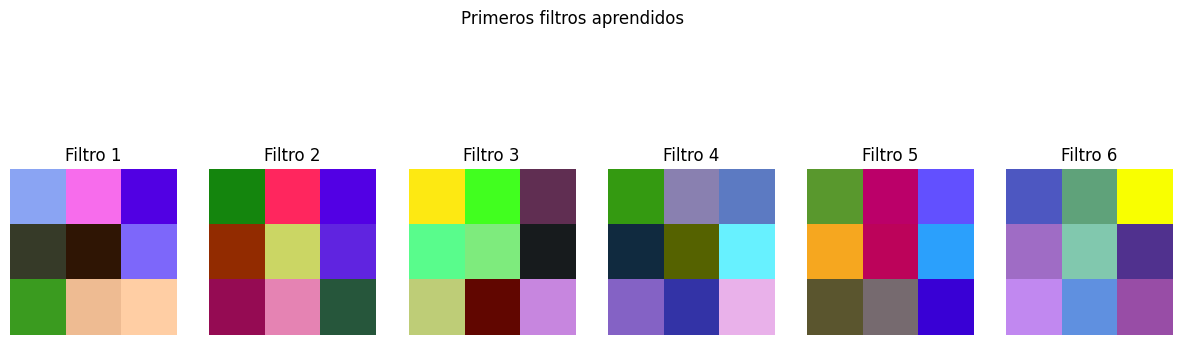

In [51]:
'''
VISUALIZAR FILTROS DE LA PRIMERA CAPA
'''

# Tomamos la primera capa convolucional
filters, biases = model.layers[0].get_weights()

# Visualizamos los primeros 6 filtros
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 6, figsize=(15,5))
for i in range(6):
    f = filters[:, :, :, i]
    f_min, f_max = f.min(), f.max()
    f = (f - f_min) / (f_max - f_min)  # Normalización para visualizar
    axs[i].imshow(f)
    axs[i].set_title(f'Filtro {i+1}')
    axs[i].axis('off')
plt.suptitle("Primeros filtros aprendidos")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


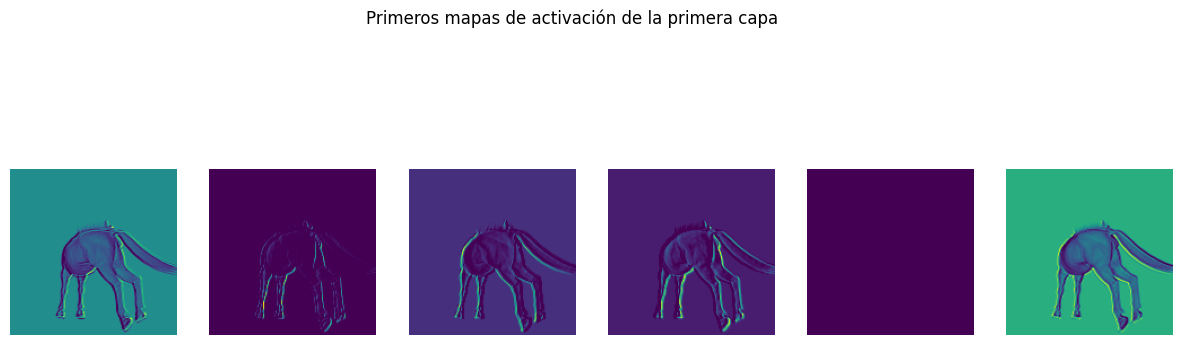

In [55]:
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# 1. Tomar input desde el primer layer (robusto)
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
activation_model = Model(inputs=model.layers[0].input, outputs=layer_outputs)

# 2. Tomar una imagen del dataset ya preprocesada (por ejemplo, de validación/test)
for sample_img, _ in ds_test_proc.take(1):
    # sample_img: shape (batch, 150, 150, 3)
    x = sample_img[0:1].numpy()  # Tomar el primer elemento y mantener batch_dim

# 3. Predecir activaciones
activations = activation_model.predict(x)

# 4. Mostrar los primeros 6 mapas de activación de la primera capa
first_layer_activation = activations[0]
fig, axs = plt.subplots(1,6, figsize=(15,5))
for i in range(6):
    axs[i].imshow(first_layer_activation[0,:,:,i], cmap='viridis')
    axs[i].axis('off')
plt.suptitle("Primeros mapas de activación de la primera capa")
plt.show()
